In [1]:
# Import all the functions you need
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import os
from pathlib import Path

# Comment here to add in for either mac or linux computer
if os.environ['SHELL'] == '/bin/bash':   # for linux
    sys.path.extend(['/data/GitHub/NeuroPy']) 
    sys.path.extend(['/data/GitHub/TraceFC/'])
else:    # For mac laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/TraceFC'])

from neuropy import core
from neuropy.io import (optitrackio,
                        dlcio,
                        )
from neuropy.io.neuroscopeio import NeuroscopeIO
from neuropy.io.binarysignalio import BinarysignalIO 
from neuropy.io.miniscopeio import MiniscopeIO
from neuropy.core import Epoch
from neuropy.utils import plot_util
from neuropy.plotting.spikes import plot_raster
from neuropy.plotting.signals import plot_signal_w_epochs
from neuropy.plotting.spikes import plot_binned_raster

In [2]:
# Define a class for a typical recording or set of recordings
class ProcessData:
    def __init__(self, basepath):
        basepath = Path(basepath)
        self.basepath = basepath
        xml_files = sorted(basepath.glob("*.xml"))
        assert len(xml_files) == 1, "Found more than one .xml file"
        
        fp = xml_files[0].with_suffix("")
        self.filePrefix = fp
        
        self.recinfo = NeuroscopeIO(xml_files[0])
        eegfiles = sorted(basepath.glob('*.eeg'))
        assert len(eegfiles) == 1, "Fewer/more than one .eeg file detected"
        self.eegfile = BinarysignalIO(eegfiles[0], n_channels=self.recinfo.n_channels,
                                     sampling_rate=self.recinfo.eeg_sampling_rate,
                                     )
        try:
            self.datfile = BinarysignalIO(eegfiles[0].with_suffix('.dat'),
                                         n_channels=self.recinfo.n_channels,
                                         sampling_rate=self.recinfo.dat_sampling_rate,
                                         )
        except FileNotFoundError:
            print('No dat file found, not loading')
                
        
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}({self.recinfo.source_file.name})"
    
def sess_use(basepath=os.getcwd()):

    return ProcessData(basepath)

In [3]:
sess = sess_use()
print(sess.recinfo)

No dat file found, not loading
filename: /Users/nkinsky/Documents/UM/Working/Trace_FC/Recording_Rats/Django/2023_03_10_recall2/Django_recall2_denoised.xml 
# channels: 134
sampling rate: 30000
lfp Srate (downsampled): 1250



In [4]:
print(sess.eegfile)

duration: 5440.61 seconds 
duration: 1.51 hours 



# Preprocess Ephys data
Identify artifacts:  
- disconnects  
- filtering  
  
Send to event files to check in Neuroscope  
Write `dead_times.txt` file for spyking-circus and `artifacts.npy` file for my own analysis.

### Identify disconnect and motion artifacts

In [5]:
from neuropy.analyses.artifact import detect_artifact_epochs
signal = sess.eegfile.get_signal()
buffer_add = 0.1  # seconds, None = don't add

art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
if art_epochs_file.exists():
    art_epochs = Epoch(epochs=None, file=art_epochs_file)
    print('Existing artifact epochs file loaded')
else:
    art_epochs = detect_artifact_epochs(signal, thresh=8, 
                                    edge_cutoff=3, merge=6)

    if buffer_add is not None:  # Add in buffer to prevent erroneous detection of start/stop of artifact as SWRs
        art_epochs.add_epoch_buffer(buffer_add)
    sess.recinfo.write_epochs(epochs=art_epochs, ext='art')
    art_epochs.save(art_epochs_file)
art_epochs

Existing artifact epochs file loaded


38 epochs
Snippet: 
        start       stop     label
0   167.9168   168.6376  artifact
1   190.1504   191.1928  artifact
2   318.3048   318.6328  artifact
3   878.2608   878.4968  artifact
4  1606.5768  1606.8504  artifact

/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


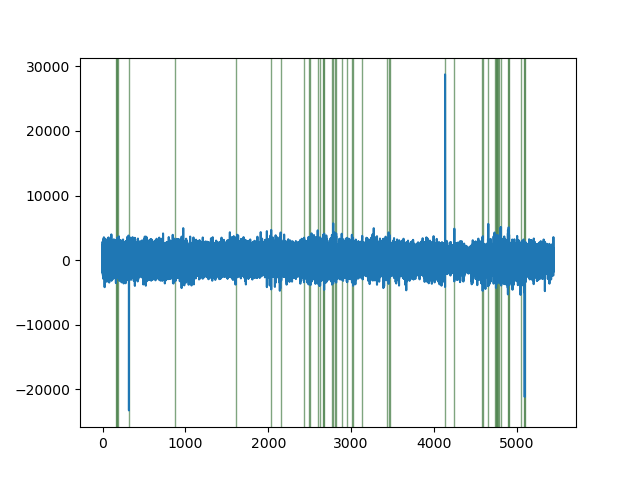

In [6]:
%matplotlib widget
_, ax = plt.subplots()
ax.plot(signal.time, signal.traces[60])

for start, stop in zip(art_epochs.starts, art_epochs.stops):
    ax.axvspan(start, stop, color=[0, 0.3, 0, 0.5])


## Define probe group

/Users/nkinsky/Documents/UM/Working/Trace_FC/Recording_Rats/Django/2023_03_10_recall2/Django_recall2_denoised.probegroup.npy saved


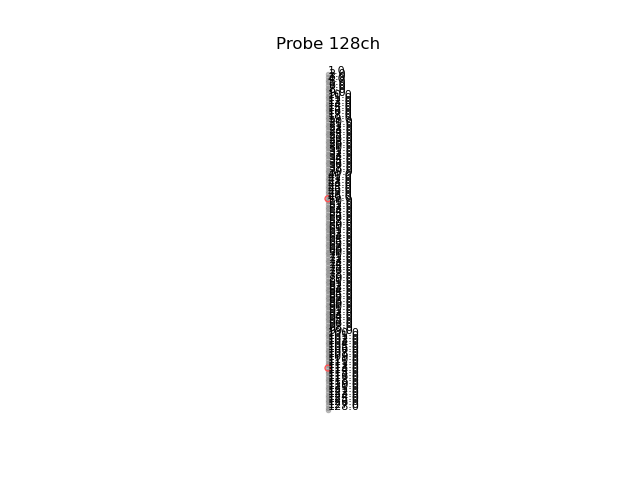

In [7]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=1, contacts_per_column=128, xpitch=0,
                   ypitch=20, channel_id=np.arange(128, 0, -1))
shank.set_disconnected_channels([48, 112])
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

# Detect Theta epochs

In [8]:
from neuropy.analyses.oscillations import detect_theta_epochs
mindur=0.25
maxdur=20
thresh = (0.5, None)
sigma = 0.125
edge_cutoff = 0.25
theta_channel = 55

# use this if you don't know theta channel
if theta_channel is None:
    theta_epochs, theta_power = detect_theta_epochs(signal, prbgrp, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)
else:
    signal_use = signal.time_slice(channel_id=theta_channel)
    theta_epochs, theta_power = detect_theta_epochs(signal_use, probegroup=None, mindur=mindur, maxdur=maxdur, thresh=thresh, 
                                                    edge_cutoff=edge_cutoff, ignore_epochs=art_epochs, return_power=True)

Best channel for theta: [55]
2465 epochs remaining with durations within (0.25,20)


In [52]:
from neuropy.utils.signal_process import FourierSg
channel_use = theta_channel
signal = sess.eegfile.get_signal()
fsg = FourierSg(signal.time_slice(channel_id=channel_use))
fsg_sm = FourierSg(signal.time_slice(channel_id=channel_use), sigma=2)
fsg_mt = FourierSg(signal.time_slice(channel_id=channel_use), multitaper=True)
fsg_mt_sm = FourierSg(signal.time_slice(channel_id=channel_use), multitaper=True, sigma=2)

In [18]:
fsg.freq_slice(5, 20).t_start

0.5

In [50]:
fsg_peri_cs[0].shape

(8, 80)

In [49]:
np.concatenate(fsg_peri_cs).shape

(176, 80)

In [46]:
buffer_sec = (5, 35)
for fsg_use, fst_type in zip([fsg, fsg_sm, fsg
fsg_peri_cs = []
for start_time in cs_oe_start_df['timestamps'].values/30000:
    ftemp = fsg_use.freq_slice(5, 12).time_slice(start_time - buffer_sec[0], start_time + buffer_sec[1])
    fsg_peri_cs.append(ftemp.traces)

_, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(fsg.freq_slice(5, 12).time_slice(1, 5000).traces, ax=ax, cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels([ int(freq) for freq in fsg.freq_slice(5, 12).freqs])

[Text(0, 0.5, '5'),
 Text(0, 1.5, '6'),
 Text(0, 2.5, '7'),
 Text(0, 3.5, '8'),
 Text(0, 4.5, '9'),
 Text(0, 5.5, '10'),
 Text(0, 6.5, '11'),
 Text(0, 7.5, '12')]

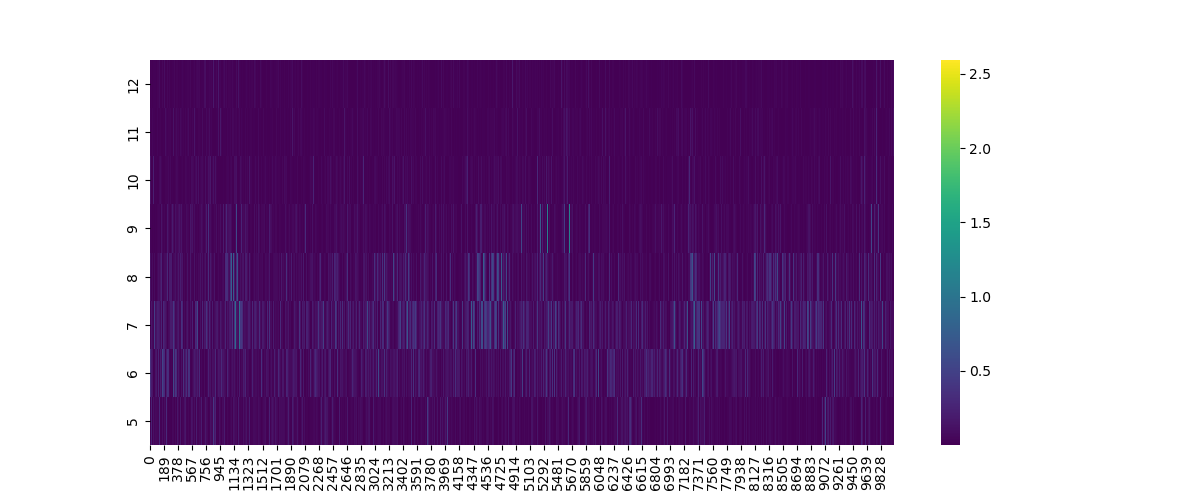

In [30]:
_, ax = plt.subplots(figsize=(12, 5))

sns.heatmap(fsg.freq_slice(5, 12).time_slice(1, 5000).traces, ax=ax, cmap='viridis')
ax.invert_yaxis()
ax.set_yticklabels([ int(freq) for freq in fsg.freq_slice(5, 12).freqs])

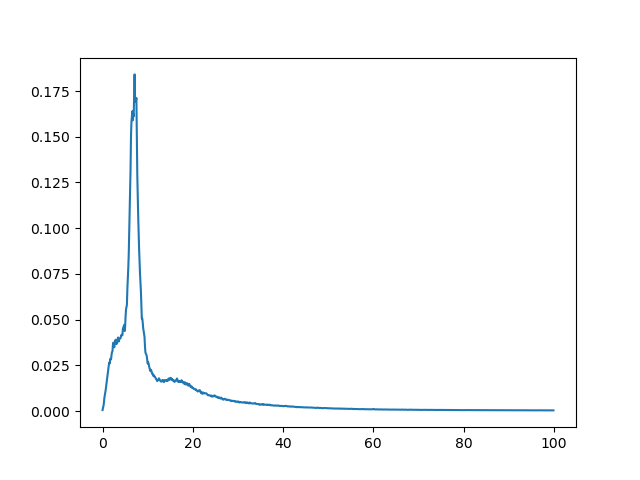

In [9]:
from neuropy.utils.signal_process import psd_auc
import scipy.signal as sg
from scipy import fftpack, stats

# theta_chan_signal = signal.time_slice(channel_id=[55, 56, 57, 58, 59, 60])
# aucChans = psd_auc(signal, freq_band=(5, 12))

# this calculates PSD for the WHOLE SESSION
channel_use = 55
window = 10
overlap = 5
freq_band = (5, 12)

fs = signal.sampling_rate
f, pxx = sg.welch(
            stats.zscore(signal.time_slice(channel_id=channel_use).traces[0]),
            fs=fs,
            nperseg=int(window * fs),
            noverlap=int(overlap * fs),
            axis=-1,
        )
f_theta = np.where((f > freq_band[0]) & (f < freq_band[1]))[0]

_, ax = plt.subplots()

ax.plot(f[f < 100], pxx[f < 100])

In [ ]:
# Now try to get power in theta for whole session
import neuropy.utils.signal_process as signal_process
from scipy.ndimage import gaussian_filter1d
channel_use = 55
window = 10
overlap = 5
freq_band = (5, 12)
thresh = (0.5, 2)
sigma = 0.125

signal_use = signal.time_slice(channel_id=channel_use).traces
fs = signal.sampling_rate

lf, hf = freq_band
dt = 1 / fs
smooth = lambda x: gaussian_filter1d(x, sigma=sigma / dt, axis=-1)
lowthresh, highthresh = thresh

# Because here one shank is selected per shank, based on visualization:
# mean: very conservative in cases where some shanks may not have that strong ripple
# max: works well but may have ocassional false positives
power = np.zeros(signal_use.shape[1])
for sig in signal_use:
    yf = signal_process.filter_sig.bandpass(sig, lf=lf, hf=hf, fs=fs)
    # zsc_chan = smooth(stats.zscore(np.abs(signal_process.hilbertfast(yf))))
    # zscsignal[sig_i] = zsc_chan
    power += np.abs(signal_process.hilbertfast(yf))

# mean and smooth
power = smooth(power / signal_use.shape[0])

In [ ]:
theta_epochs2.metadata

In [ ]:
# Now plot these epochs for sanity checks
%matplotlib widget
_, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
plot_signal_w_epochs(signal, channel_use, theta_epochs2, ax=ax[0])
ax[0].set_title('Raw Signal with theta epochs')
theta_power_sig = signal.time_slice(channel_id=channel_use)
theta_power_sig.traces = theta_power[None, :]
# theta_power_sig.traces = stats.zscore(power)[None, :]
plot_signal_w_epochs(theta_power_sig, 0, theta_epochs2, ax=ax[1])
ax[1].set_title('Theta power signal with theta epochs')
ax[1].axhline(thresh[0], color='r', linestyle='--')
ax[1].axhline(thresh[1], color='r', linestyle='--')

In [ ]:
buffer = 1
peri_start_power = []
peri_stop_power = []
for start, stop in zip(theta_epochs2.starts, theta_epochs2.stops):
    start_bool = np.bitwise_and(signal.time > (start - buffer), signal.time < (start + buffer))
    stop_bool = np.bitwise_and(signal.time > (stop - buffer), signal.time < (stop + buffer))
    peri_start_power.append(theta_power[start_bool])
    peri_stop_power.append(theta_power[stop_bool])

In [ ]:
peri_start_power2 = [start_times if len(start_times) == int(buffer*2*1250) else np.nan*np.ones(int(buffer*2*1250)) for start_times in peri_start_power]
peri_start_power2 = np.array(peri_start_power2)
peri_start_power2 = peri_start_power2[~np.isnan(peri_start_power2).all(axis=1)]
peri_stop_power2 = [stop_times if len(stop_times) == int(buffer*2*1250) else np.nan*np.ones(int(buffer*2*1250)) for stop_times in peri_stop_power]
peri_stop_power2 = np.array(peri_stop_power2)
peri_stop_power2 = peri_stop_power2[~np.isnan(peri_stop_power2).all(axis=1)]

In [ ]:
# Sanity checks on theta power detection - looks great!
_, ax = plt.subplots(1, 3, figsize=(8, 3), layout='tight')
times = np.linspace(-buffer, buffer, int(fs*2*buffer))

# Starts
sns.heatmap(peri_start_power2, ax=ax[0], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(peri_start_power2)-1),
            xticklabels=(int(len(times)/2))-1)
ax[0].set_xlabel('Time from theta start (s)')
ax[0].set_xticklabels([-buffer, 0, buffer])
ax[0].set_ylabel('Theta epoch #')
# ax[0].

# Stops
sns.heatmap(peri_stop_power2, ax=ax[1], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(peri_stop_power2)-1),
            xticklabels=(int(len(times)/2))-1)
ax[1].set_xlabel('Time from theta stop (s)')
ax[1].set_xticklabels([-buffer, 0, buffer])
ax[1].set_ylabel('Theta epoch #')

# Means
hstart = ax[2].plot(times, peri_start_power2.mean(axis=0), 'k-')
hstop = ax[2].plot(times, peri_stop_power2.mean(axis=0), 'g--')
ax[2].legend((hstart, hstop), ('Start', 'Stop'))
ax[2].set_title('Mean theta power')
ax[2].set_xlabel('Time from epoch start/stop (s)')
ax[2].set_ylabel('Theta power (z)')

Ok, seems like things are working well - nice peack in theta after onset and before offset,

In [ ]:
_, ax = plt.subplots()

sns.histplot(theta_epochs.durations, bins=100, stat='probability', cumulative=False, ax=ax)
ax.set_title('Theta epochs')
ax.set_xlabel('Theta epoch length (s)')

# Import CS timestamps

In [31]:
import neuropy.io.openephysio as oeio

# Import TTLs for CS from OpenEphys
ttl_df = oeio.load_all_ttl_events(sess.basepath)
ttl_df[ttl_df['channel_states'] == 2].head(5)

,channel_states,timestamps,datetimes,event_name
919,2,16856515,2023-03-10 12:39:11.883833333,
1851,2,18737123,2023-03-10 12:40:14.570766667,
2754,2,20557304,2023-03-10 12:41:15.243466667,
3671,2,22407930,2023-03-10 12:42:16.931000000,
4604,2,24288544,2023-03-10 12:43:19.618133333,


In [32]:
import tracefc.io.traceio as traceio
cs_starts, cs_ends, cs_df = traceio.load_trace_events(sess.basepath, session_type="tone_recall", event_type="CS+",
                                                      return_df=True)
print(cs_starts.shape[0])
cs_starts.head(5)

22


,Time (s),Event,Timestamp
5,61.779992,CS1_start,2023-03-10 12:39:12.213177104
7,124.467165,CS2_start,2023-03-10 12:40:14.900350232
9,185.140091,CS3_start,2023-03-10 12:41:15.573275942
11,246.827830,CS4_start,2023-03-10 12:42:17.261015076
13,309.515002,CS5_start,2023-03-10 12:43:19.948187011


In [33]:
# Need to figure out a way to filter out/collect only the proper time stamps assuming things have a 
# +/- 1 second start difference in the CSV vs OpenEphys

# Make below a function 'calc_cs_lag' in traceio module.
start_diff = (ttl_df[ttl_df['channel_states'] == 2].head(15)['datetimes'] - cs_starts.head(15)['Timestamp'].values)
start_diff_mean = pd.Timedelta(np.abs(start_diff.dt.total_seconds().mean()), unit='seconds')
start_diff_mean

Timedelta('0 days 00:00:00.330591522')

In [34]:
def trace_ttl_to_openephys(trace_cs_df: pd.DataFrame, oe_ttls_df: pd.DataFrame, ttl_lag=pd.Timedelta(0.33, unit='seconds'), 
                           trace_ts_key='Timestamp', oe_ts_key='datetimes'):
    """Finds TTLs in OpenEphys that correspond to CS timestamps recorded from python in a CSV file, assuming a consistent
    time lag from CS start to delivery in OpenEphys
    ttl_lag: amount of time OE LAGS the csv in tracefc csv. Enter a negative number if lag is positive for some reason."""

    cs_bool = np.zeros(len(oe_ttls_df[oe_ts_key]), dtype=bool)
    for event in trace_cs_df[trace_ts_key]:
        cs_bool = cs_bool | ((oe_ttls_df[oe_ts_key] > (event - ttl_lag)) & (oe_ttls_df[oe_ts_key] < (event)))

    return oe_ttls_df[cs_bool]

In [43]:
cs_oe_start_df['timestamps']

919      16856515
1851     18737123
2754     20557304
3671     22407930
4604     24288544
5657     26413135
6860     28842175
7988     31118085
9162     33486714
10095    35367786
11042    37278822
11945    39099019
12953    41132297
14066    43378208
15179    45624567
17292    54382690
18284    56385024
19473    58783617
20421    60695118
21549    62971475
17543    37221555
18716    39589208
Name: timestamps, dtype: int64

In [41]:
# Grab CS times corresponding to OE timestamps
cs_oe_start_df = trace_ttl_to_openephys(cs_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=start_diff_mean*1.1)

cs_oe_end_df = trace_ttl_to_openephys(cs_ends, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=start_diff_mean*1.1)

In [37]:
from neuropy.io.openephysio import create_sync_df
sync_df = create_sync_df(sess.basepath)
sync_df

ValueError: need at least one array to concatenate

In [ ]:
from itertools import compress

# Next, step through each row and figure out if it matches a starts/end
cs_oe_starts = cs_oe_start_df['timestamps']/sess.recinfo.dat_sampling_rate
cs_oe_ends = cs_oe_end_df['timestamps']/sess.recinfo.dat_sampling_rate

buffer = 5
cs_start_power = []
cs_stop_power = []
for start, stop in zip(cs_oe_starts, cs_oe_ends):
    start_bool = np.bitwise_and(signal.time > (start - buffer), signal.time < (start + buffer))
    stop_bool = np.bitwise_and(signal.time > (stop - buffer), signal.time < (stop + buffer))
    cs_start_power.append(theta_power[start_bool])
    cs_stop_power.append(theta_power[stop_bool])

cs_start_power = np.array(list(compress(cs_start_power, [len(start) == int(buffer*2*1250) for start in cs_start_power])))
cs_stop_power = np.array(list(compress(cs_stop_power, [len(stop) == int(buffer*2*1250) for stop in cs_stop_power])))

In [ ]:
# Now plot theta power
_, ax = plt.subplots(1, 3, figsize=(8, 3), layout='tight')
times = np.linspace(-buffer, buffer, int(fs*2*buffer))

# Starts
sns.heatmap(cs_start_power, ax=ax[0], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(peri_start_power2)-1),
            xticklabels=(int(len(times)/2))-1)
ax[0].set_xlabel('Time from CS+ start (s)')
ax[0].set_xticklabels([-buffer, 0, buffer])
ax[0].set_ylabel('CS+ #')
# ax[0].

# Stops
sns.heatmap(cs_stop_power, ax=ax[1], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(peri_stop_power2)-1),
            xticklabels=(int(len(times)/2))-1)
ax[1].set_xlabel('Time from CS+ stop (s)')
ax[1].set_xticklabels([-buffer, 0, buffer])
ax[1].set_ylabel('CS+ #')

# Means
hstart = ax[2].plot(times, cs_start_power.mean(axis=0), 'k-')
hstop = ax[2].plot(times, cs_stop_power.mean(axis=0), 'g--')
ax[2].legend((hstart, hstop), ('Start', 'Stop'))
ax[2].set_title('Mean theta power')
ax[2].set_xlabel('Time from CS+ start/stop (s)')
ax[2].set_ylabel('Theta power (z)')

In [ ]:
# Same for CS-
csn_starts, csn_ends, csn_df = traceio.load_trace_events(sess.basepath, session_type="control_tone_recall", event_type="CS-",
                                                      return_df=True)

In [ ]:
# Grab CS times corresponding to OE timestamps
csn_oe_start_df = trace_ttl_to_openephys(csn_starts, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=start_diff_mean*1.1)

csn_oe_end_df = trace_ttl_to_openephys(csn_ends, 
                                  ttl_df[ttl_df['channel_states'].abs() == 2], 
                                  ttl_lag=start_diff_mean*1.1)

In [ ]:
from itertools import compress

# Next, step through each row and figure out if it matches a starts/end
csn_oe_starts = csn_oe_start_df['timestamps']/sess.recinfo.dat_sampling_rate
csn_oe_ends = csn_oe_end_df['timestamps']/sess.recinfo.dat_sampling_rate

buffer = 5
csn_start_power = []
csn_stop_power = []
for start, stop in zip(csn_oe_starts, csn_oe_ends):
    start_bool = np.bitwise_and(signal.time > (start - buffer), signal.time < (start + buffer))
    stop_bool = np.bitwise_and(signal.time > (stop - buffer), signal.time < (stop + buffer))
    csn_start_power.append(theta_power[start_bool])
    csn_stop_power.append(theta_power[stop_bool])

csn_start_power = np.array(list(compress(csn_start_power, [len(start) == int(buffer*2*1250) for start in csn_start_power])))
csn_stop_power = np.array(list(compress(csn_stop_power, [len(stop) == int(buffer*2*1250) for stop in csn_stop_power])))

In [ ]:
# Now plot theta power
, ax = plt.subplots(1, 3, figsize=(8, 3), layout='tight')
times = np.linspace(-buffer, buffer, int(fs*2*buffer))

# Starts
sns.heatmap(csn_start_power, ax=ax[0], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(csn_start_power)-1),
            xticklabels=(int(len(times)/2))-1)
ax[0].set_xlabel('Time from CS- start (s)')
ax[0].set_xticklabels([-buffer, 0, buffer])
ax[0].set_ylabel('CS- #')
# ax[0].

# Stops
sns.heatmap(csn_stop_power, ax=ax[1], cbar_kws={'label': 'Theta power (z)'}, yticklabels=(len(csn_stop_power)-1),
            xticklabels=(int(len(times)/2))-1)
ax[1].set_xlabel('Time from CS- stop (s)')
ax[1].set_xticklabels([-buffer, 0, buffer])
ax[1].set_ylabel('CS- #')

# Means
hstart = ax[2].plot(times, csn_start_power.mean(axis=0), 'k-')
hstop = ax[2].plot(times, csn_stop_power.mean(axis=0), 'g--')
ax[2].legend((hstart, hstop), ('Start', 'Stop'))
ax[2].set_title('Mean theta power')
ax[2].set_xlabel('Time from CS- start/stop (s)')
ax[2].set_ylabel('Theta power (z)')

# Detect Population Burst Events

In [ ]:
# 1) Detect MUA.

# 1a) Load in neuron spiketrains from phy
from neuropy.io.phyio import PhyIO
dirname = Path('/data3/Trace_FC/Recording_Rats/Django/2023_03_10_recall2/spyk-circ/Django_recall2_denoised/Django_recall2_denoised-merged.GUI')
phy = PhyIO(dirname)

# 1b) Convert spiketrains to Neurons class
from neuropy.core.neurons import Neurons
neurons = Neurons(phy.spiketrains, sess.eegfile.duration)
# 1c) Convert Neurons class data to MUA class
mua = neurons.get_mua(bin_size=0.05)

# 2) Run PBE detection.
from neuropy.analyses.spkepochs import detect_pbe_epochs
pbe_epochs = detect_pbe_epochs(mua)

# 3) Export to neuroscope
type(pbe_epochs)
sess.recinfo.write_epochs(pbe_epochs, ext = "pbe")


In [ ]:
pbe_epochs

In [ ]:
%matplotlib inline
_, ax = plt.subplots()

ax.plot(mua.firing_rate)

In [ ]:
dirname / "spike_trains.npy"

In [ ]:
sess.pyr_neurons.spiketrains[1]

# Load in neurons to Neuroscope

In [ ]:
# Read in event timestamps
session_type = 'tone_recall'

from neuropy.io.openephysio import load_all_ttl_events, get_dat_timestamps
events_df = load_all_ttl_events(sorted(sess.basepath.glob(f"**/*{session_type}"))[0])
dat_timestamps = get_dat_timestamps(sess.basepath)

In [ ]:
dat_times_zeroed = (dat_timestamps - dat_timestamps.iloc[0])[0].dt.total_seconds().to_numpy()

In [ ]:
CStimes_zeroed = [(CSon - dat_timestamps.iloc[0]).dt.total_seconds()[0] for CSon in CSon_times]

In [ ]:
tbefore = 10
tafter = 40
CSon_tstamps = (events_df[events_df["channel_states"] == 2]['datetimes'] - dat_timestamps.iloc[0])
CSon_times = events_df[events_df["channel_states"] == 2]['datetimes']
CSon_times

In [ ]:
def PSTH(neurons: Neurons, neuron_id, times_zeroed, tbefore=10, tafter=40, ax=None):
    """Plot peri-stimulus raster"""
    
    # Grab appropriate neuron's spike times and pre-allocate
    spiketimes = neurons.spiketrains[neuron]
    ps_spike_times = []
    
    # Build up peri-stimulus spike times
    for stim_start in times_zeroed:
        trial_bool = np.bitwise_and(spiketimes > (stim_start - tbefore), spiketimes < (stim_start + tafter))
        ps_spike_times.append(spiketimes[trial_bool] - stim_start)
    
    # Send to Neurons class for easy manipulation and plotting
    rast = Neurons(ps_spike_times, t_start=-tbefore, t_stop=tafter, sampling_rate=1)
    
    # Plot raster
    ax = plot_raster(rast, ax=ax)
    
    return rast, ax

In [ ]:
def CS_PSTH(neurons, neuron_id, times_zeroed, tbefore=10, tafter=40, CSdur=10, USlag=30, 
            CStype='CS+' in ['CS+', 'CS-'], training=False, ax=None):
    """Plots peri-stimulus time histogram for each CS with colors overlaid for CS duration
    and US lag"""
    
    # Plot raster
    rast, ax = PSTH(neurons, neuron_id, times_zeroed, tbefore=tbefore, tafter=tafter, ax=ax)
    
    # Add in colors for CS duration
    assert CStype in ['CS+', 'CS-']
    if CStype == 'CS+':
        CScolor = [1, 0.647, 0, 0.3]
    else:
        CScolor = [0, 1, 0, 0.3]
    ax.axvspan(0, CSdur, color=CScolor)
    
    # Add in US line
    linetype = '-' if training else '--'
    ax.axvline(USlag, linestyle=linetype, color='r')
    
    return rast, ax

In [ ]:
for 

In [ ]:
pyr_ind = np.where([ neuron in [1, 2, 3] for neuron in sess.pyr_neurons.neuron_type])[0]
np.ceil(len(pyr_ind)/3).astype(int)

In [ ]:
binned_sp = rast.get_binned_spiketrains(bin_size=0.5)

In [ ]:
binned_sp.spike_counts.mean(axis=0)

In [ ]:
from neuropy.plotting.spikes import plot_firing_rate
rast, ax = PSTH(sess.pyr_neurons, 0, CStimes_zeroed)
plot_firing_rate(rast, bin_size=0.5, stacked=True)

In [ ]:
ncols = 3

# Pyramidal neurons
pyr_ind = np.where([ neuron in [1, 2, 3] for neuron in sess.pyr_neurons.neuron_type])[0]
fig, ax = plt.subplots(np.ceil(len(pyr_ind)/ncols).astype(int), ncols)
fig.set_size_inches(10, 3*np.ceil(len(pyr_ind)/ncols).astype(int))
fig.suptitle('Pyr neurons')

for a, neuron in zip(ax.reshape(-1), pyr_ind):
    CS_PSTH(sess.pyr_neurons, neuron, CStimes_zeroed, CStype='CS+', ax=a)

# MUA
mua_ind = np.where(sess.pyr_neurons.neuron_type == 6)[0]
fig, ax = plt.subplots(np.ceil(len(mua_ind)/ncols).astype(int), ncols)
fig.set_size_inches(10, 3*np.ceil(len(mua_ind)/ncols).astype(int))
fig.suptitle('MUA')

for a, neuron in zip(ax.reshape(-1), mua_ind):
    CS_PSTH(sess.pyr_neurons, neuron, CStimes_zeroed, CStype='CS+', ax=a)
    
# Interneurons
int_ind = np.where(sess.pyr_neurons.neuron_type == 8)[0]
fig, ax = plt.subplots(np.ceil(len(int_ind)/ncols).astype(int), ncols)
fig.set_size_inches(10, 3*np.ceil(len(int_ind)/ncols).astype(int))
fig.suptitle('Interneurons')

for a, neuron in zip(ax.reshape(-1), int_ind):
    CS_PSTH(sess.pyr_neurons, neuron, CStimes_zeroed, CStype='CS+', ax=a)

In [ ]:
ax.figure.get_size_inches()

In [ ]:
sess.pyr_neurons.neuron_type

In [ ]:
# Super slow!!!
neuron = 3
spiketimes = sess.pyr_neurons.spiketrains[neuron]
raster = []
for CSon in CStimes_zeroed:
    trial_bool = np.bitwise_and(spiketimes > (CSon - tbefore), spiketimes < (CSon + tafter))
    raster.append(spiketimes[trial_bool] - CSon)

In [ ]:
rast1 = Neurons(raster, t_start=-tbefore, t_stop=tafter, sampling_rate=1)

In [ ]:
plot_raster(rast1)

In [ ]:
events_df[events_df["channel_states"].abs() == 2]

Calculate MUA

In [ ]:
sess.mua = sess.pyr_neurons.get_mua(bin_size=0.05)

Import curated ripple data

In [ ]:
from neuropy.core.epoch import Epoch
sess.ripple = Epoch(epochs=None, file=sess.filePrefix.with_suffix('.ripple_curated.npy'))

In [ ]:
a = sess.ripple.to_dataframe()

# Detect ripples and theta

NRK - try running this with a) more aggressive artifact filter and b) selecting a better ripple channel and c) adding in a sharpwave channel too  
  
Also, need to run spyking-circus with median filter AND on different session - maybe less noisy/better with different preamp?

In [ ]:
from neuropy.core.epoch import Epoch
art_epochs = Epoch(epochs=None, file=sess.filePrefix.with_suffix('.art_epochs.npy'))

In [ ]:
from neuropy.utils import signal_process
pyr_ch = 57
sw_ch = 84
signal = sess.eegfile.get_signal()
yripple = signal_process.filter_sig.bandpass(signal.traces[pyr_ch], 150, 250, 1250)
ysw = signal_process.filter_sig.bandpass(signal.traces[sw_ch], 2, 50, 1250)

In [ ]:
import scipy.stats as stats
zsc_ripple = stats.zscore(np.abs(signal_process.hilbertfast(yripple)))
zsc_sw = stats.zscore(np.abs(signal_process.hilbertfast(ysw)))

In [ ]:
from neuropy.analyses import oscillations
signal = sess.eegfile.get_signal()
# old method
# ripple_epochs = oscillations.detect_ripple_epochs(signal, sess.prbgrp, thresh=(1, 3),
#                                                   ignore_epochs=art_epochs, mindur=0.025)

# new method
ripple_epochs = oscillations.detect_ripple_epochs(signal, sess.prbgrp, thresh=(4, None), 
                                                  ripple_channel=pyr_ch,
                                                  ignore_epochs=art_epochs, mindur=0.1)
ripple_epochs.source_file = sess.filePrefix.with_suffix(".ripple.npy")
sess.ripple_epochs = ripple_epochs
sess.recinfo.write_epochs(sess.ripple_epochs, 'swr')
sess.ripple_epochs.save(sess.filePrefix.with_suffix('.ripple.npy'))

In [ ]:
sw_epochs = oscillations.detect_sharpwave_epochs(signal, sess.prbgrp, thresh=(4, None),
                                                 edge_cutoff=1.5, ignore_epochs=art_epochs,
                                                 sharpwave_channel=12)

In [ ]:
# sw_epochs.source_file = sess.filePrefix.with_suffix(".sharpwave.npy")
sess.recinfo.write_epochs(sw_epochs, 'swv')
sess.sw_epochs = sw_epochs
sess.sw_epochs.save(sess.filePrefix.with_suffix('.ripple.npy'))

In [ ]:
%matplotlib notebook
plot_artifact = False
plot_sw = True
fig, ax = plt.subplots()
# ax.plot(np.arange(len(yripple))/1250, yripple)
ax.plot(np.arange(len(yripple))/1250, zsc_ripple)
ax.set_xlabel('Time (sec)')
# ax.plot(np.arange(len(ysw))/1250, zsc_sw, '--')
h, legend_text = [], []
if plot_artifact:
    for ind, epoch in art_epochs._epochs.iterrows():
        hart = ax.axvspan(epoch['start'], epoch['stop'], color=[0, 1, 0, 0.3])
    h.append(hart)
    legend_text.append('Artifact')
    
for ind, epoch in ripple_epochs._epochs.iterrows():
    hswr = ax.axvspan(epoch['start'], epoch['stop'], color=[1, 0, 0, 0.3])
h.append(hswr)
legend_text.append('Ripple')
    
if plot_sw:
    for ind, epoch in sw_epochs._epochs.iterrows():
        hswv = ax.axvspan(epoch['start'], epoch['stop'], color=[0.5, 0.5, 0, 0.3])
    h.append(hswv)
    legend_text.append('Sharp Wave')

plt.legend(h, legend_text)
# ax.set_xlim([2922.8, 2924.2])

### Combine epochs and get power in both bands across events and then plot and run k-means

In [ ]:
# Ok, combine epochs and then get power in both bands across al
# candidate events
comb_epochs = pd.concat((ripple_epochs.to_dataframe(), 
                         sw_epochs.to_dataframe()))
candidate_bool = np.zeros(sess.eegfile.n_frames, dtype=bool)
SR = sess.eegfile.sampling_rate

for idr, epoch in comb_epochs.iterrows():
    start_frame = int(epoch['start'] * SR)
    end_frame = int(epoch['stop'] * SR)
    candidate_bool[start_frame:end_frame] = True

candidate_bool = np.concatenate(([0], candidate_bool))
cand_diff = np.diff(candidate_bool)
cand_start = np.where(cand_diff == 1)[0]
cand_end = np.where(cand_diff == -1)[0]
epochs_array = np.vstack((cand_start, cand_end)).T.astype(int)
cand_epochs = pd.DataFrame(
            {"start": epochs_array[:, 0], "stop": epochs_array[:, 1], "label": ""}
        )

In [ ]:
from neuropy.utils import signal_process
import scipy.stats as stats
pyr_ch = 24
sw_ch = 31
signal = sess.eegfile.get_signal()
yripple = signal_process.filter_sig.bandpass(signal.traces[pyr_ch], 150, 250, 1250)
ysw = signal_process.filter_sig.bandpass(signal.traces[sw_ch], 2, 50, 1250)
zsc_ripple = stats.zscore(np.abs(signal_process.hilbertfast(yripple)))
zsc_sw = stats.zscore(np.abs(signal_process.hilbertfast(ysw)))

In [ ]:
sw_power, ripple_power = [], []
for idr, row in cand_epochs.iterrows():
    start = row['start']
    end = row['stop']
    ripple_z = zsc_ripple[start:end]
    ripple_power.append([ripple_z.mean(), ripple_z.max()])
    
    sw_z = zsc_sw[start:end]
    sw_power.append([sw_z.mean(), sw_z.max()])

ripple_power = np.asarray(ripple_power)
sw_power = np.asarray(sw_power)

In [ ]:
from sklearn.cluster import KMeans
mean_features = np.vstack((sw_power[:,0], ripple_power[:, 0])).T
max_features = np.vstack((sw_power[:,1], ripple_power[:, 1])).T
kmeans = KMeans(n_clusters=3, random_state=0).fit(max_features)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8,3))
n_clusters = 3
for ida, (a, title) in enumerate(zip(ax, ['Mean', 'Max'])):
    features = np.vstack((sw_power[:,ida], ripple_power[:, ida])).T
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(features)
    for feat_id in np.unique(kmeans.labels_):
        feat_bool = feat_id == kmeans.labels_
        sns.scatterplot(x=features[feat_bool, 0], y=features[feat_bool, 1], 
                        ax=a, size=3, alpha=0.5)
    a.set_title(title + ' Epoch Power')
    a.set_xlabel('SW z-score')
    a.set_ylabel('Ripple z-score')
    a.legend([])
                                 

In [ ]:
ext='test'
ripple_epochs.filename.with_suffix(f".evt.{ext}")

In [ ]:
# NRK debug this!
sess.ripple_epochs.epochs = sess.ripple_epochs.to_dataframe()
NeuroscopeIO.write_epochs(sess.ripple_epochs, 'swr')

In [ ]:
sw_epochs.to_dataframe()

# Ok, now write code to step through each ripple event and ok it by hand - should go super fast!!